In [55]:
import pandas as pd
import re

path = "D:\\23F-0636-DS-A4\\marks_dataset.xlsx"
xls = pd.ExcelFile(path)

normalized_sheets = {}

for sheet in xls.sheet_names:
    df = pd.read_excel(path, sheet_name=sheet)

    # ---- 0. RENAME FIRST COLUMN TO Sr.# ----
    first_col = df.columns[0]
    if "unnamed" in str(first_col).lower():
        df.rename(columns={first_col: "Sr.#"}, inplace=True)
    else:
        df.rename(columns={first_col: "Sr.#"}, inplace=True)

    labels = df["Sr.#"].astype(str).str.lower()

    # ---- 1. REMOVE Sr.# ROW ----
    sr_row_idx = labels[labels.str.contains("sr") & labels.str.contains("#")].index
    if len(sr_row_idx) > 0:
        df = df.drop(sr_row_idx).reset_index(drop=True)

    labels = df["Sr.#"].astype(str).str.lower()

    # ---- 2. WEIGHTAGE ROW ----
    weightage_index = labels[labels.str.contains("weight", na=False)].index
    weightage_index = weightage_index[0] if len(weightage_index) > 0 else None

    # ---- 3. TOTAL ROW ----
    total_index = labels[labels.str.contains("total", na=False)].index
    if len(total_index) == 0:
        print(f"⚠ No TOTAL row in '{sheet}'. Skipping.")
        continue
    total_index = total_index[0]

    # ---- 4. SAVE TOTAL ROW ----
    total_row = df.loc[total_index]

    # ---- 5. DROP weightage + total rows ----
    rows_to_drop = [total_index]
    if weightage_index is not None:
        rows_to_drop.append(weightage_index)

    # ➤ Extract WEIGHTAGE row for special normalization
    if weightage_index is not None:
        weightage_row = df.loc[weightage_index]
    else:
        weightage_row = None

    df = df.drop(rows_to_drop).reset_index(drop=True)

    # ---- 6. NUMERIC COLUMNS ----
    numeric_cols = df.columns[1:]

    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    total_numeric = pd.to_numeric(total_row[numeric_cols], errors='coerce')

    # ➤ Extract numeric weightage values
    if weightage_row is not None:
        weightage_numeric = pd.to_numeric(weightage_row[numeric_cols], errors='coerce')
    else:
        weightage_numeric = None

    # ---- 7. NORMALIZATION ----
    for col in numeric_cols:

        # ➤ Special rule: normalize s_i, s_ii, final using WEIGHTAGE row
        if weightage_numeric is not None and col in ["S-I", "S-II", "Final"]:
            if pd.notna(weightage_numeric[col]) and weightage_numeric[col] != 0:
                df[col] = df[col] / weightage_numeric[col]
            continue

        # Normal rule: use TOTAL row
        if pd.notna(total_numeric[col]) and total_numeric[col] != 0:
            df[col] = df[col] / total_numeric[col]

    # ---- 8. SAVE CLEAN SHEET ----
    normalized_sheets[sheet] = df


In [56]:
data = pd.concat(normalized_sheets.values(), ignore_index=True)


In [57]:
data.shape

(254, 31)

In [58]:
data.columns.tolist()


['Sr.#',
 'As:1',
 'As:2',
 'As:3',
 'As:4',
 'As:5',
 'As:6',
 'Qz:1',
 'Qz:2',
 'Qz:3',
 'Qz:4',
 'Qz:5',
 'Qz:6',
 'Qz:7',
 'Qz:8',
 'S-I:1',
 'S-I',
 'S-II:1',
 'S-II',
 'Final:1',
 'Final',
 'Proj:1',
 'Proj',
 'S-I:2',
 'S-I:3',
 'S-II:2',
 'S-II:3',
 'Final:2',
 'Final:3',
 'Final:4',
 'Final:5']

In [59]:
data.head(3)


,Sr.#,As:1,As:2,As:3,As:4,As:5,As:6,Qz:1,Qz:2,Qz:3,...,Proj:1,Proj,S-I:2,S-I:3,S-II:2,S-II:3,Final:2,Final:3,Final:4,Final:5
0,1,0.619231,0.864286,0.816667,0.81,0.491667,0.783333,0.7,0.333333,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.557692,0.971429,0.433333,0.70,0.670833,0.788889,0.5,0.466667,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.869231,0.885714,0.000000,0.94,0.666667,0.888889,0.7,0.166667,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
data.columns = (data.columns
                .str.strip()
                .str.lower()
                .str.replace(' ', '_')
                .str.replace('-', '_')
                .str.replace(r'[^\w_]', '', regex=True))

In [61]:
data.columns.tolist()


['sr',
 'as1',
 'as2',
 'as3',
 'as4',
 'as5',
 'as6',
 'qz1',
 'qz2',
 'qz3',
 'qz4',
 'qz5',
 'qz6',
 'qz7',
 'qz8',
 's_i1',
 's_i',
 's_ii1',
 's_ii',
 'final1',
 'final',
 'proj1',
 'proj',
 's_i2',
 's_i3',
 's_ii2',
 's_ii3',
 'final2',
 'final3',
 'final4',
 'final5']

In [62]:
import re

def find_cols(pattern):
    return [col for col in data.columns if re.search(pattern, col)]

assignment_cols = find_cols(r'^as\d+')
quiz_cols       = find_cols(r'^qz\d+')
sessional_cols  = find_cols(r's_i|s_ii')
project_cols    = find_cols(r'proj')
final_cols      = find_cols(r'final')

print("Assignments:", assignment_cols)
print("Quizzes:", quiz_cols)
print("Sessionals:", sessional_cols)
print("Projects:", project_cols)
print("Finals:", final_cols)


Assignments: ['as1', 'as2', 'as3', 'as4', 'as5', 'as6']
Quizzes: ['qz1', 'qz2', 'qz3', 'qz4', 'qz5', 'qz6', 'qz7', 'qz8']
Sessionals: ['s_i1', 's_i', 's_ii1', 's_ii', 's_i2', 's_i3', 's_ii2', 's_ii3']
Projects: ['proj1', 'proj']
Finals: ['final1', 'final', 'final2', 'final3', 'final4', 'final5']


In [63]:
data.head()

,sr,as1,as2,as3,as4,as5,as6,qz1,qz2,qz3,...,proj1,proj,s_i2,s_i3,s_ii2,s_ii3,final2,final3,final4,final5
0,1,0.619231,0.864286,0.816667,0.81,0.491667,0.783333,0.7,0.333333,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0.557692,0.971429,0.433333,0.70,0.670833,0.788889,0.5,0.466667,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0.869231,0.885714,0.000000,0.94,0.666667,0.888889,0.7,0.166667,0.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0.469231,0.621429,0.000000,0.44,NaN,0.555556,0.3,0.333333,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0.800000,0.957143,0.805556,0.90,1.000000,1.000000,1.0,0.700000,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sr      254 non-null    object 
 1   as1     246 non-null    float64
 2   as2     247 non-null    float64
 3   as3     246 non-null    float64
 4   as4     242 non-null    float64
 5   as5     141 non-null    float64
 6   as6     55 non-null     float64
 7   qz1     248 non-null    float64
 8   qz2     248 non-null    float64
 9   qz3     249 non-null    float64
 10  qz4     244 non-null    float64
 11  qz5     236 non-null    float64
 12  qz6     225 non-null    float64
 13  qz7     128 non-null    float64
 14  qz8     58 non-null     float64
 15  s_i1    254 non-null    float64
 16  s_i     254 non-null    float64
 17  s_ii1   252 non-null    float64
 18  s_ii    251 non-null    float64
 19  final1  254 non-null    float64
 20  final   254 non-null    float64
 21  proj1   38 non-null     float64
 22  pr

In [65]:
data.describe(include='all')

,sr,as1,as2,as3,as4,as5,as6,qz1,qz2,qz3,...,proj1,proj,s_i2,s_i3,s_ii2,s_ii3,final2,final3,final4,final5
count,254.0,246.000000,247.000000,246.000000,242.000000,141.000000,55.000000,248.000000,248.000000,249.000000,...,38.000000,37.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
unique,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.586123,0.615999,0.667982,0.639571,0.667302,0.768157,0.474395,0.349664,0.430924,...,0.639474,1.969730,0.075245,0.645098,0.220915,0.582353,0.568137,0.604902,0.265196,0.299755
std,NaN,0.265988,0.305368,0.241212,0.302488,0.275124,0.177006,0.307036,0.286758,0.276508,...,0.208001,0.542737,0.151825,0.165683,0.250716,0.272947,0.246539,0.285683,0.249070,0.231477
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,...,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.401250,0.535000,0.551389,0.484375,0.550000,0.640972,0.200000,0.100000,0.200000,...,0.512500,1.650000,0.000000,0.562500,0.066667,0.350000,0.412500,0.441667,0.066667,0.125000
50%,NaN,0.630385,0.728571,0.729583,0.725000,0.725000,0.800000,0.500000,0.333333,0.437500,...,0.675000,2.100000,0.050000,0.650000,0.133333,0.612500,0.575000,0.650000,0.166667,0.250000
75%,NaN,0.811298,0.822500,0.841667,0.875000,0.875000,0.912500,0.700000,0.533333,0.600000,...,0.800000,2.400000,0.100000,0.750000,0.266667,0.800000,0.750000,0.833333,0.425000,0.425000


In [66]:
data.isna().sum()

sr          0
as1         8
as2         7
as3         8
as4        12
as5       113
as6       199
qz1         6
qz2         6
qz3         5
qz4        10
qz5        18
qz6        29
qz7       126
qz8       196
s_i1        0
s_i         0
s_ii1       2
s_ii        3
final1      0
final       0
proj1     216
proj      217
s_i2      152
s_i3      152
s_ii2     152
s_ii3     152
final2    152
final3    152
final4    152
final5    152
dtype: int64

In [67]:
data.columns = data.columns.str.lower().str.strip()


In [68]:
data = data.drop_duplicates()


In [69]:
threshold = 0.95
cols_to_drop = data.columns[data.isna().mean() > threshold]
data = data.drop(columns=cols_to_drop)
cols_to_drop


Index([], dtype='object')

In [70]:
meaningful_cols = assignment_cols + quiz_cols + sessional_cols + project_cols + final_cols
data = data.dropna(subset=meaningful_cols, how='all')


In [71]:
data.isna().mean().sort_values(ascending=False)


proj      0.854331
proj1     0.850394
as6       0.783465
qz8       0.771654
final3    0.598425
final2    0.598425
s_ii3     0.598425
s_i2      0.598425
s_i3      0.598425
s_ii2     0.598425
final4    0.598425
final5    0.598425
qz7       0.496063
as5       0.444882
qz6       0.114173
qz5       0.070866
as4       0.047244
qz4       0.039370
as1       0.031496
as3       0.031496
as2       0.027559
qz1       0.023622
qz2       0.023622
qz3       0.019685
s_ii      0.011811
s_ii1     0.007874
sr        0.000000
final1    0.000000
final     0.000000
s_i       0.000000
s_i1      0.000000
dtype: float64

In [72]:
part_columns = [
    's_i1', 's_i2', 's_i3',
    's_ii1', 's_ii2', 's_ii3',
    'final1', 'final2', 'final3', 'final4', 'final5',
    'proj1','proj'
]

# Only drop if exist in dataset
cols_to_drop = [col for col in part_columns if col in data.columns]

data = data.drop(columns=cols_to_drop)


In [73]:
data.columns.tolist()


['sr',
 'as1',
 'as2',
 'as3',
 'as4',
 'as5',
 'as6',
 'qz1',
 'qz2',
 'qz3',
 'qz4',
 'qz5',
 'qz6',
 'qz7',
 'qz8',
 's_i',
 's_ii',
 'final']

In [74]:
data.isna().mean().sort_values(ascending=False)



as6      0.783465
qz8      0.771654
qz7      0.496063
as5      0.444882
qz6      0.114173
qz5      0.070866
as4      0.047244
qz4      0.039370
as3      0.031496
as1      0.031496
as2      0.027559
qz1      0.023622
qz2      0.023622
qz3      0.019685
s_ii     0.011811
sr       0.000000
s_i      0.000000
final    0.000000
dtype: float64

In [75]:
data.shape

(254, 18)

In [76]:


df = data.copy()   # your merged + normalized dataset

# 1. Drop columns with >50% missing
cols_to_drop = df.columns[df.isna().mean() > 0.50]
df = df.drop(columns=cols_to_drop)

print("Dropped columns:", list(cols_to_drop))




Dropped columns: ['as6', 'qz8']


In [77]:
# 2. Identify numeric columns (except target variables)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# remove target columns (you can adjust names)
target_cols = ["s_i", "s_ii","final"]

numeric_cols = [c for c in numeric_cols if c not in target_cols]

# 3. Median fill for remaining missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# 4. Drop rows where target is missing
df = df.dropna(subset=target_cols, how="all")

print("✓ Missing-value cleaning completed.")

✓ Missing-value cleaning completed.


In [78]:
df.isna().mean().sort_values(ascending=False)


s_ii     0.011811
sr       0.000000
as2      0.000000
as1      0.000000
as4      0.000000
as5      0.000000
qz1      0.000000
as3      0.000000
qz2      0.000000
qz3      0.000000
qz5      0.000000
qz4      0.000000
qz6      0.000000
qz7      0.000000
s_i      0.000000
final    0.000000
dtype: float64

In [79]:
df.head(50)

,sr,as1,as2,as3,as4,as5,qz1,qz2,qz3,qz4,qz5,qz6,qz7,s_i,s_ii,final
0,1,0.619231,0.864286,0.816667,0.81,0.491667,0.7,0.333333,0.2000,0.80,0.40,0.5,0.750000,0.437333,0.156000,0.357333
1,2,0.557692,0.971429,0.433333,0.70,0.670833,0.5,0.466667,0.0000,1.00,0.70,1.0,0.833333,0.312000,0.274667,0.534889
2,3,0.869231,0.885714,0.000000,0.94,0.666667,0.7,0.166667,0.1000,0.10,0.20,0.2,1.000000,0.237333,0.162000,0.324889
3,4,0.469231,0.621429,0.000000,0.44,0.725000,0.3,0.333333,0.0500,0.00,0.00,0.2,0.250000,0.462000,0.224667,0.280000
4,5,0.800000,0.957143,0.805556,0.90,1.000000,1.0,0.700000,1.0000,1.00,0.65,1.0,0.750000,0.712000,0.437333,0.747333
5,6,0.000000,0.742857,0.677778,0.41,0.458333,0.9,0.366667,0.1500,0.00,0.80,0.8,0.250000,0.262000,0.100000,0.394889
6,7,0.907692,0.885714,0.950000,0.79,0.908333,1.0,0.566667,0.9500,1.00,0.70,0.9,0.833333,0.568667,0.343333,0.704889
7,8,0.000000,0.671429,0.488889,0.46,0.425000,0.4,0.400000,0.0500,0.00,0.10,0.5,0.250000,0.162000,0.124667,0.132444
8,9,0.807692,0.928571,0.750000,0.94,0.775000,0.7,0.566667,0.0000,0.10,0.10,0.4,0.750000,0.350000,0.606000,0.582444
9,10,0.869231,0.842857,0.572222,0.66,0.550000,0.9,0.133333,0.0500,0.00,0.00,0.3,0.166667,0.224667,0.118667,0.277333


In [81]:
df.columns.tolist()


['sr',
 'as1',
 'as2',
 'as3',
 'as4',
 'as5',
 'qz1',
 'qz2',
 'qz3',
 'qz4',
 'qz5',
 'qz6',
 'qz7',
 's_i',
 's_ii',
 'final']

#Final Clean DATASET

In [108]:
df.shape

(254, 16)

In [109]:
df= df.dropna()

In [138]:
df.to_csv("cleandata.csv")


In [ ]:
df.isna().mean().sort_values(ascending=False)

sr       0.0
as1      0.0
as2      0.0
as3      0.0
as4      0.0
as5      0.0
qz1      0.0
qz2      0.0
qz3      0.0
qz4      0.0
qz5      0.0
qz6      0.0
qz7      0.0
s_i      0.0
s_ii     0.0
final    0.0
dtype: float64

In [112]:
# 1) Imports + helpers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.base import clone

RND = 42
np.random.seed(RND)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def bootstrap_oob_mae(model_pipeline, X_train, y_train, n_boot=500, random_state=RND):
    """Bootstrap on TRAIN ONLY. For each bootstrap: fit on bootstrap sample,
    evaluate MAE on out-of-bag (OOB) training rows not included in sample."""
    rng = np.random.RandomState(random_state)
    n = X_train.shape[0]
    maes = []
    for i in range(n_boot):
        idx = rng.randint(0, n, size=n)  # bootstrap indices
        oob_mask = np.ones(n, dtype=bool)
        oob_mask[idx] = False
        if oob_mask.sum() == 0:
            continue
        X_boot, y_boot = X_train[idx], y_train[idx]
        model_pipeline.fit(X_boot, y_boot)
        X_oob, y_oob = X_train[oob_mask], y_train[oob_mask]
        pred_oob = model_pipeline.predict(X_oob)
        maes.append(mean_absolute_error(y_oob, pred_oob))
    return np.array(maes)


In [113]:
# Basic information
print(df.shape)
print(df.head())
print(df.info())
print(df.describe())

(251, 16)
  sr       as1       as2       as3   as4       as5  qz1       qz2   qz3  qz4  \
0  1  0.619231  0.864286  0.816667  0.81  0.491667  0.7  0.333333  0.20  0.8   
1  2  0.557692  0.971429  0.433333  0.70  0.670833  0.5  0.466667  0.00  1.0   
2  3  0.869231  0.885714  0.000000  0.94  0.666667  0.7  0.166667  0.10  0.1   
3  4  0.469231  0.621429  0.000000  0.44  0.725000  0.3  0.333333  0.05  0.0   
4  5  0.800000  0.957143  0.805556  0.90  1.000000  1.0  0.700000  1.00  1.0   

    qz5  qz6       qz7       s_i      s_ii     final  
0  0.40  0.5  0.750000  0.437333  0.156000  0.357333  
1  0.70  1.0  0.833333  0.312000  0.274667  0.534889  
2  0.20  0.2  1.000000  0.237333  0.162000  0.324889  
3  0.00  0.2  0.250000  0.462000  0.224667  0.280000  
4  0.65  1.0  0.750000  0.712000  0.437333  0.747333  
<class 'pandas.core.frame.DataFrame'>
Index: 251 entries, 0 to 253
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   

<Figure size 1400x1000 with 0 Axes>

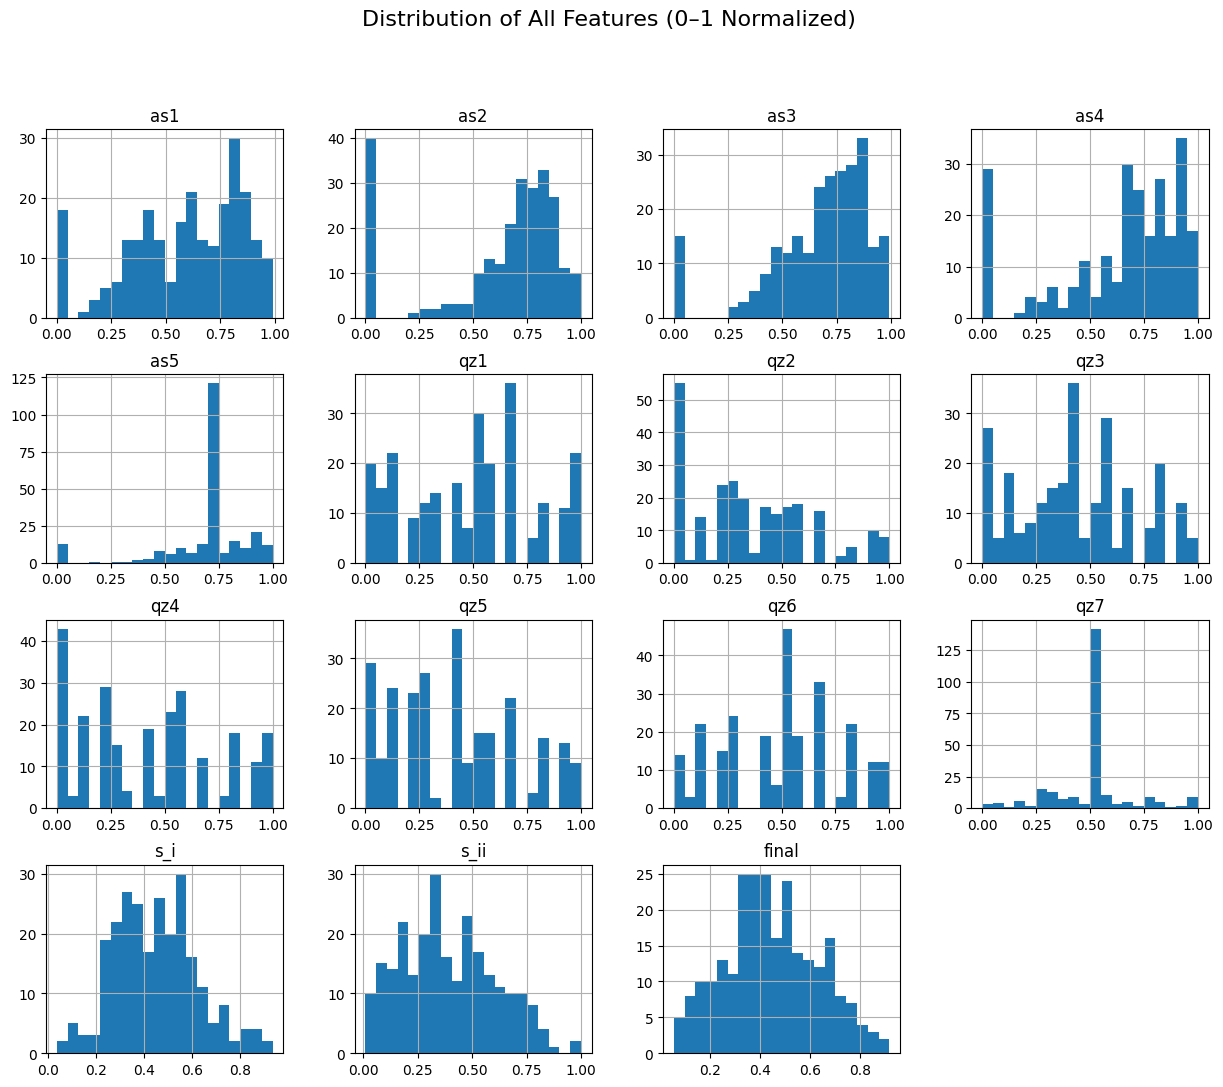

In [114]:
plt.figure(figsize=(14, 10))
df.drop(columns=['sr']).hist(bins=20, figsize=(15, 12))
plt.suptitle("Distribution of All Features (0–1 Normalized)", fontsize=16)
plt.show()


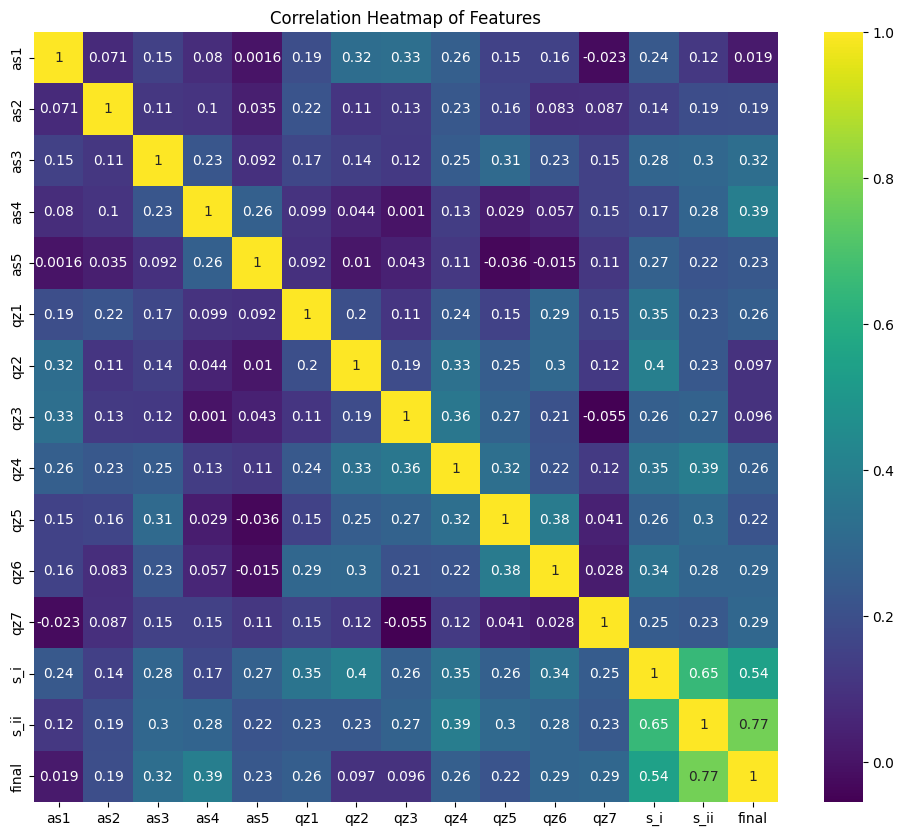

In [115]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop(columns=['sr']).corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap of Features")
plt.show()


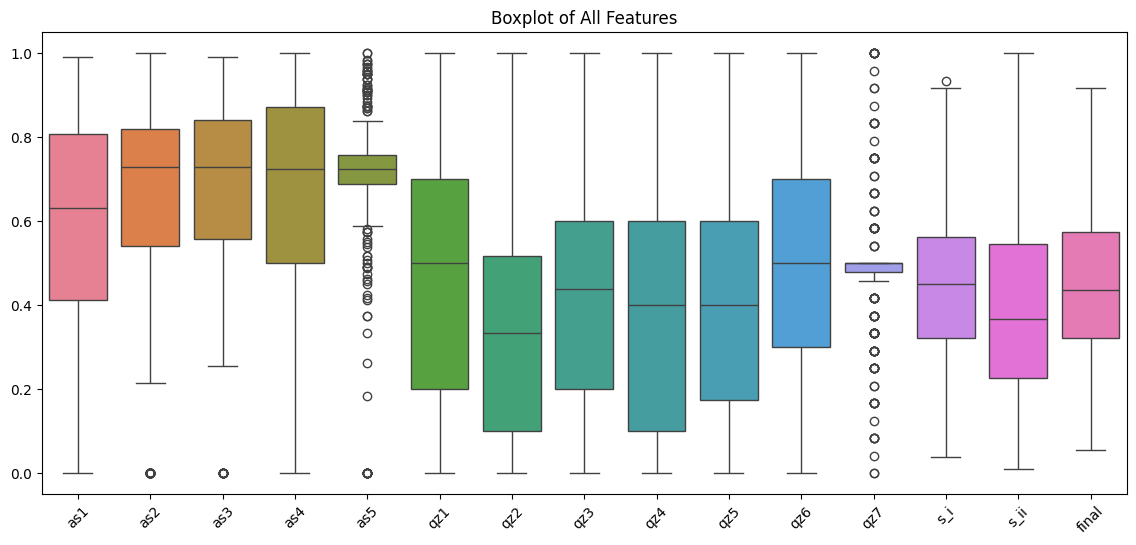

In [116]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df.drop(columns=['sr']))
plt.xticks(rotation=45)
plt.title("Boxplot of All Features")
plt.show()


In [117]:
if 'sr' in df.columns:
    df_model = df.drop(columns=['sr']).copy()
else:
    df_model = df.copy()

# quick check
display(df_model.head())
display(df_model.describe().T)

,as1,as2,as3,as4,as5,qz1,qz2,qz3,qz4,qz5,qz6,qz7,s_i,s_ii,final
0,0.619231,0.864286,0.816667,0.81,0.491667,0.7,0.333333,0.20,0.8,0.40,0.5,0.750000,0.437333,0.156000,0.357333
1,0.557692,0.971429,0.433333,0.70,0.670833,0.5,0.466667,0.00,1.0,0.70,1.0,0.833333,0.312000,0.274667,0.534889
2,0.869231,0.885714,0.000000,0.94,0.666667,0.7,0.166667,0.10,0.1,0.20,0.2,1.000000,0.237333,0.162000,0.324889
3,0.469231,0.621429,0.000000,0.44,0.725000,0.3,0.333333,0.05,0.0,0.00,0.2,0.250000,0.462000,0.224667,0.280000
4,0.800000,0.957143,0.805556,0.90,1.000000,1.0,0.700000,1.00,1.0,0.65,1.0,0.750000,0.712000,0.437333,0.747333


,count,mean,std,min,25%,50%,75%,max
as1,251.0,0.587142,0.262683,0.000000,0.411250,0.630385,0.807692,0.990000
as2,251.0,0.618254,0.302174,0.000000,0.540833,0.728571,0.820000,1.000000
as3,251.0,0.672116,0.235178,0.000000,0.557778,0.729583,0.841667,0.991667
as4,251.0,0.645144,0.294497,0.000000,0.500000,0.725000,0.872500,1.000000
as5,251.0,0.692555,0.207867,0.000000,0.687500,0.725000,0.756250,1.000000
qz1,251.0,0.478685,0.303008,0.000000,0.200000,0.500000,0.700000,1.000000
qz2,251.0,0.351328,0.284020,0.000000,0.100000,0.333333,0.516667,1.000000
qz3,251.0,0.433217,0.273985,0.000000,0.200000,0.437500,0.600000,1.000000
qz4,251.0,0.416279,0.321319,0.000000,0.100000,0.400000,0.600000,1.000000
qz5,251.0,0.400996,0.288772,0.000000,0.175000,0.400000,0.600000,1.000000


In [118]:
# 2) Feature sets (domain-respecting)
assign_cols = ['as1','as2','as3','as4','as5']
quiz_cols   = ['qz1','qz2','qz3','qz4','qz5','qz6','qz7']

# Targets
mid1 = 's_i'     # RQ1 target
mid2 = 's_ii'    # RQ2 target
final_col = 'final'  # RQ3 target

# Features per RQ (no leakage)
features_rq1 = assign_cols + quiz_cols                         # predict mid1 (s_i): cannot use s_ii/final
features_rq2 = assign_cols + quiz_cols + [mid1]                # predict mid2 (s_ii): may use s_i
features_rq3 = assign_cols + quiz_cols + [mid1, mid2]          # predict final: can use both mids

print("RQ1 features:", features_rq1)
print("RQ2 features:", features_rq2)
print("RQ3 features:", features_rq3)


RQ1 features: ['as1', 'as2', 'as3', 'as4', 'as5', 'qz1', 'qz2', 'qz3', 'qz4', 'qz5', 'qz6', 'qz7']
RQ2 features: ['as1', 'as2', 'as3', 'as4', 'as5', 'qz1', 'qz2', 'qz3', 'qz4', 'qz5', 'qz6', 'qz7', 's_i']
RQ3 features: ['as1', 'as2', 'as3', 'as4', 'as5', 'qz1', 'qz2', 'qz3', 'qz4', 'qz5', 'qz6', 'qz7', 's_i', 's_ii']


In [119]:
# 3) Train-test splits (80/20)
def create_split(X_df, y_series, test_size=0.2, random_state=RND):
    return train_test_split(X_df, y_series, test_size=test_size, random_state=random_state)

# Prepare arrays (scikit-learn pipelines accept numpy arrays or DataFrames)
X1 = df_model[features_rq1]
y1 = df_model[mid1]
X2 = df_model[features_rq2]
y2 = df_model[mid2]
X3 = df_model[features_rq3]
y3 = df_model[final_col]

X1_train, X1_test, y1_train, y1_test = create_split(X1, y1)
X2_train, X2_test, y2_train, y2_test = create_split(X2, y2)
X3_train, X3_test, y3_train, y3_test = create_split(X3, y3)

print("Sizes (train/test):")
print("RQ1:", X1_train.shape[0], "/", X1_test.shape[0])
print("RQ2:", X2_train.shape[0], "/", X2_test.shape[0])
print("RQ3:", X3_train.shape[0], "/", X3_test.shape[0])


Sizes (train/test):
RQ1: 200 / 51
RQ2: 200 / 51
RQ3: 200 / 51


In [120]:
# 4) Pipelines
def make_dummy():
    return DummyRegressor(strategy='mean')

def make_linear():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])

def make_poly_deg2(alpha=1.0):
    # Standardize -> polynomial features -> ridge regression
    return Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=alpha, random_state=RND))
    ])

# quick check
dummy = make_dummy()
linear = make_linear()
poly2 = make_poly_deg2(alpha=1.0)


In [121]:
# 5) Bootstrap OOB MAE
def bootstrap_oob_mae(model_pipeline, X_train, y_train, n_boot=500, random_state=RND):
    """
    For each bootstrap iteration:
      - sample indices with replacement from train to create bootstrap sample
      - fit model on bootstrap sample
      - evaluate MAE on the out-of-bag (OOB) samples (train indices not selected)
    Returns: numpy array of MAE values (length <= n_boot)
    """
    rng = np.random.RandomState(random_state)
    n = X_train.shape[0]
    maes = []
    for i in range(n_boot):
        idx = rng.randint(0, n, size=n)  # bootstrap indices (with replacement)
        oob_mask = np.ones(n, dtype=bool)
        oob_mask[idx] = False
        if oob_mask.sum() == 0:
            # rare: all indices were sampled; skip
            continue
        X_boot = X_train.iloc[idx] if isinstance(X_train, pd.DataFrame) else X_train[idx]
        y_boot = y_train.iloc[idx] if isinstance(y_train, pd.Series) else y_train[idx]
        model = clone(model_pipeline)
        model.fit(X_boot, y_boot)
        # evaluate on OOB
        X_oob = X_train.iloc[oob_mask] if isinstance(X_train, pd.DataFrame) else X_train[oob_mask]
        y_oob = y_train.iloc[oob_mask] if isinstance(y_train, pd.Series) else y_train[oob_mask]
        pred_oob = model.predict(X_oob)
        maes.append(mean_absolute_error(y_oob, pred_oob))
    return np.array(maes)


In [122]:
# 6) Evaluate one model fully
def evaluate_model(X_train, X_test, y_train, y_test, model_pipeline, name, n_boot=500):
    # fit on full training set
    model = clone(model_pipeline)
    model.fit(X_train, y_train)
    # predictions
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)
    # metrics
    metrics = {
        'model': name,
        'MAE_test': mean_absolute_error(y_test, pred_test),
        'RMSE_test': rmse(y_test, pred_test),
        'R2_test': r2_score(y_test, pred_test),
        'MAE_train': mean_absolute_error(y_train, pred_train),
        'RMSE_train': rmse(y_train, pred_train),
        'R2_train': r2_score(y_train, pred_train)
    }
    # bootstrap MAE (OOB on train)
    mae_boot = bootstrap_oob_mae(clone(model_pipeline), X_train, y_train, n_boot=n_boot, random_state=RND)
    if len(mae_boot) > 0:
        low, high = np.percentile(mae_boot, [2.5, 97.5])
    else:
        low, high = (np.nan, np.nan)
    metrics['MAE_boot_mean'] = mae_boot.mean() if len(mae_boot)>0 else np.nan
    metrics['MAE_boot_2.5pct'] = low
    metrics['MAE_boot_97.5pct'] = high

    return metrics, mae_boot, model


In [123]:
# 7) Experiment runner
def run_models_for_rq(X_train, X_test, y_train, y_test, model_list):
    results = []
    boots = {}
    fitted_models = {}
    for pipe_func, name in model_list:
        pipe = pipe_func()
        stats, boot_arr, fitted = evaluate_model(X_train, X_test, y_train, y_test, pipe, name, n_boot=500)
        results.append(stats)
        boots[name] = boot_arr
        fitted_models[name] = fitted
    df_res = pd.DataFrame(results).set_index('model')
    return df_res, boots, fitted_models

models_to_run = [
    (make_dummy, 'DummyMean'),
    (make_linear, 'LinearRegression'),
    (lambda: make_poly_deg2(alpha=1.0), 'PolyDeg2_Ridge')
]

# RQ1
df_rq1_results, boots_rq1, fitted_rq1 = run_models_for_rq(X1_train, X1_test, y1_train, y1_test, models_to_run)
# RQ2
df_rq2_results, boots_rq2, fitted_rq2 = run_models_for_rq(X2_train, X2_test, y2_train, y2_test, models_to_run)
# RQ3
df_rq3_results, boots_rq3, fitted_rq3 = run_models_for_rq(X3_train, X3_test, y3_train, y3_test, models_to_run)

# Display
print("RQ1 results")
display(df_rq1_results)
print("RQ2 results")
display(df_rq2_results)
print("RQ3 results")
display(df_rq3_results)


RQ1 results


,MAE_test,RMSE_test,R2_test,MAE_train,RMSE_train,R2_train,MAE_boot_mean,MAE_boot_2.5pct,MAE_boot_97.5pct
model,,,,,,,,,
DummyMean,0.145406,0.187919,-0.004611,0.136537,0.166722,0.000000,0.136987,0.119693,0.154914
LinearRegression,0.116443,0.142519,0.422170,0.108514,0.131858,0.374502,0.118365,0.102419,0.134757
PolyDeg2_Ridge,0.144923,0.194871,-0.080313,0.079908,0.101217,0.631428,0.221830,0.171889,0.291560


RQ2 results


,MAE_test,RMSE_test,R2_test,MAE_train,RMSE_train,R2_train,MAE_boot_mean,MAE_boot_2.5pct,MAE_boot_97.5pct
model,,,,,,,,,
DummyMean,0.162877,0.211623,-0.002535,0.186876,0.218753,0.000000,0.187589,0.165578,0.208776
LinearRegression,0.129621,0.165543,0.386532,0.120021,0.150652,0.525713,0.133487,0.112465,0.152820
PolyDeg2_Ridge,0.198145,0.251711,-0.418333,0.080764,0.103369,0.776708,0.286500,0.217034,0.377621


RQ3 results


,MAE_test,RMSE_test,R2_test,MAE_train,RMSE_train,R2_train,MAE_boot_mean,MAE_boot_2.5pct,MAE_boot_97.5pct
model,,,,,,,,,
DummyMean,0.157757,0.197041,-0.009524,0.152433,0.185938,0.000000,0.152946,0.134546,0.173228
LinearRegression,0.104148,0.132621,0.542674,0.081880,0.098418,0.719837,0.091243,0.078410,0.103105
PolyDeg2_Ridge,0.156651,0.211227,-0.160115,0.050972,0.065551,0.875714,0.210206,0.165040,0.272223


In [ ]:
cols_report = ['MAE_test','RMSE_test','R2_test','MAE_boot_2.5pct','MAE_boot_97.5pct','MAE_train','R2_train']

print("RQ1 comparison")
display(df_rq1_results[cols_report])
print("RQ2 comparison")
display(df_rq2_results[cols_report])
print("RQ3 comparison")
display(df_rq3_results[cols_report])


RQ1 comparison


,MAE_test,RMSE_test,R2_test,MAE_boot_2.5pct,MAE_boot_97.5pct,MAE_train,R2_train
model,,,,,,,
DummyMean,0.145406,0.187919,-0.004611,0.119693,0.154914,0.136537,0.000000
LinearRegression,0.116443,0.142519,0.422170,0.102419,0.134757,0.108514,0.374502
PolyDeg2_Ridge,0.144923,0.194871,-0.080313,0.171889,0.291560,0.079908,0.631428


RQ2 comparison


,MAE_test,RMSE_test,R2_test,MAE_boot_2.5pct,MAE_boot_97.5pct,MAE_train,R2_train
model,,,,,,,
DummyMean,0.162877,0.211623,-0.002535,0.165578,0.208776,0.186876,0.000000
LinearRegression,0.129621,0.165543,0.386532,0.112465,0.152820,0.120021,0.525713
PolyDeg2_Ridge,0.198145,0.251711,-0.418333,0.217034,0.377621,0.080764,0.776708


RQ3 comparison


,MAE_test,RMSE_test,R2_test,MAE_boot_2.5pct,MAE_boot_97.5pct,MAE_train,R2_train
model,,,,,,,
DummyMean,0.157757,0.197041,-0.009524,0.134546,0.173228,0.152433,0.000000
LinearRegression,0.104148,0.132621,0.542674,0.078410,0.103105,0.081880,0.719837
PolyDeg2_Ridge,0.156651,0.211227,-0.160115,0.165040,0.272223,0.050972,0.875714


Best model for RQ1 (s_i): LinearRegression

MAE_test            0.116443
RMSE_test           0.142519
R2_test             0.422170
MAE_train           0.108514
RMSE_train          0.131858
R2_train            0.374502
MAE_boot_mean       0.118365
MAE_boot_2.5pct     0.102419
MAE_boot_97.5pct    0.134757
Name: LinearRegression, dtype: float64


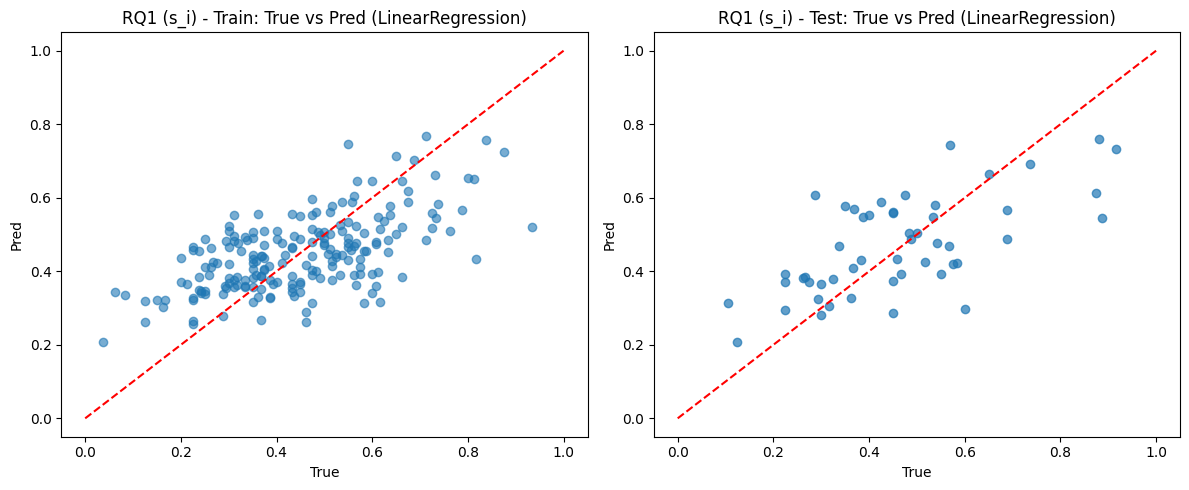

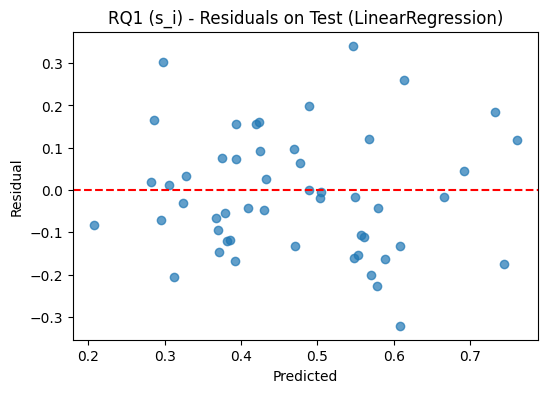

Best model for RQ2 (s_ii): LinearRegression

MAE_test            0.129621
RMSE_test           0.165543
R2_test             0.386532
MAE_train           0.120021
RMSE_train          0.150652
R2_train            0.525713
MAE_boot_mean       0.133487
MAE_boot_2.5pct     0.112465
MAE_boot_97.5pct    0.152820
Name: LinearRegression, dtype: float64


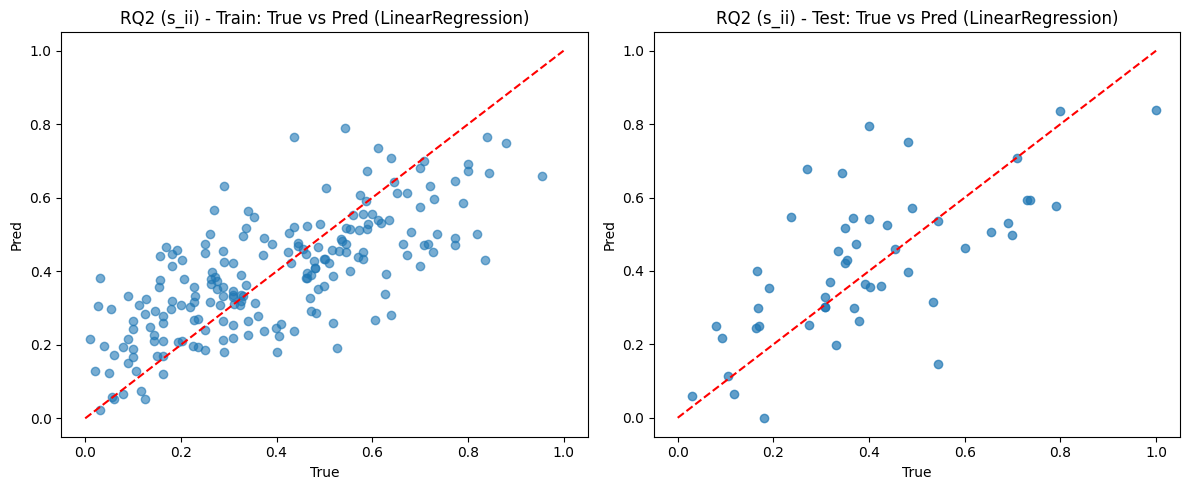

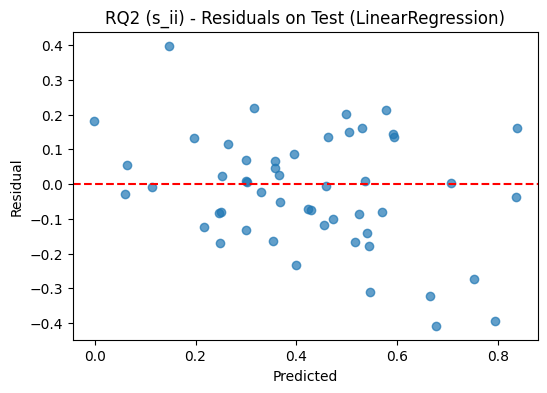

Best model for RQ3 (final): LinearRegression

MAE_test            0.104148
RMSE_test           0.132621
R2_test             0.542674
MAE_train           0.081880
RMSE_train          0.098418
R2_train            0.719837
MAE_boot_mean       0.091243
MAE_boot_2.5pct     0.078410
MAE_boot_97.5pct    0.103105
Name: LinearRegression, dtype: float64


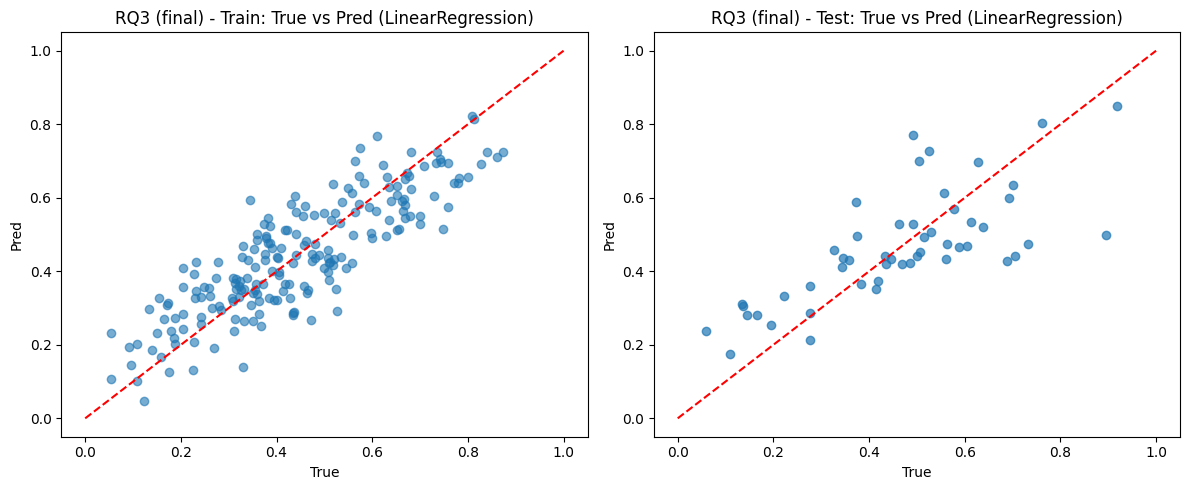

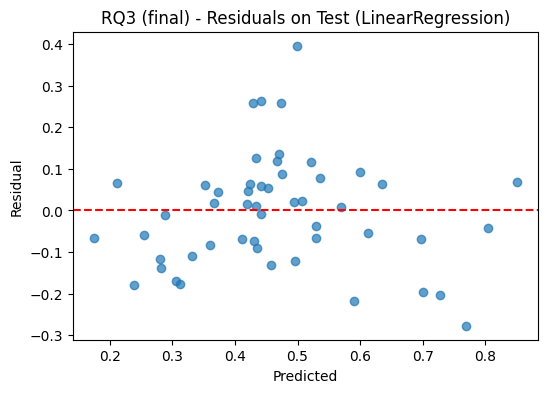

In [125]:
# 9) Inspect best model visually and show train/test metrics
def show_best_model(df_results, fitted_models, X_train, X_test, y_train, y_test, rq_name):
    best_name = df_results['MAE_test'].idxmin()
    best_model = fitted_models[best_name]
    print(f"Best model for {rq_name}: {best_name}\n")
    print(df_results.loc[best_name])
    # predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test  = best_model.predict(X_test)

    # Scatter plots: true vs predicted
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_train, y_pred_train, alpha=0.6)
    plt.plot([0,1],[0,1], 'r--')
    plt.title(f'{rq_name} - Train: True vs Pred ({best_name})')
    plt.xlabel('True'); plt.ylabel('Pred')

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_test, alpha=0.7)
    plt.plot([0,1],[0,1], 'r--')
    plt.title(f'{rq_name} - Test: True vs Pred ({best_name})')
    plt.xlabel('True'); plt.ylabel('Pred')

    plt.tight_layout()
    plt.show()

    # Residual plot on test
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_test, residuals, alpha=0.7)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(f'{rq_name} - Residuals on Test ({best_name})')
    plt.xlabel('Predicted'); plt.ylabel('Residual')
    plt.show()

# Show for each RQ
show_best_model(df_rq1_results, fitted_rq1, X1_train, X1_test, y1_train, y1_test, 'RQ1 (s_i)')
show_best_model(df_rq2_results, fitted_rq2, X2_train, X2_test, y2_train, y2_test, 'RQ2 (s_ii)')
show_best_model(df_rq3_results, fitted_rq3, X3_train, X3_test, y3_train, y3_test, 'RQ3 (final)')


Finding Best Model

In [131]:
df_rq1_results.head()


,MAE_test,RMSE_test,R2_test,MAE_train,RMSE_train,R2_train,MAE_boot_mean,MAE_boot_2.5pct,MAE_boot_97.5pct
model,,,,,,,,,
DummyMean,0.145406,0.187919,-0.004611,0.136537,0.166722,0.000000,0.136987,0.119693,0.154914
LinearRegression,0.116443,0.142519,0.422170,0.108514,0.131858,0.374502,0.118365,0.102419,0.134757
PolyDeg2_Ridge,0.144923,0.194871,-0.080313,0.079908,0.101217,0.631428,0.221830,0.171889,0.291560


In [132]:
df_rq1_results.columns


Index(['MAE_test', 'RMSE_test', 'R2_test', 'MAE_train', 'RMSE_train',
       'R2_train', 'MAE_boot_mean', 'MAE_boot_2.5pct', 'MAE_boot_97.5pct'],
      dtype='object')

In [133]:
df_rq1_results.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, DummyMean to PolyDeg2_Ridge
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MAE_test          3 non-null      float64
 1   RMSE_test         3 non-null      float64
 2   R2_test           3 non-null      float64
 3   MAE_train         3 non-null      float64
 4   RMSE_train        3 non-null      float64
 5   R2_train          3 non-null      float64
 6   MAE_boot_mean     3 non-null      float64
 7   MAE_boot_2.5pct   3 non-null      float64
 8   MAE_boot_97.5pct  3 non-null      float64
dtypes: float64(9)
memory usage: 348.0+ bytes


In [134]:
def get_best_model(results_df, fitted_models_dict):
    # Sort by test R2 column name
    best_model_name = results_df.sort_values("R2_test", ascending=False).index[0]
    
    # Return model name + fitted instance
    return best_model_name, fitted_models_dict[best_model_name]


In [135]:
from sklearn.metrics import r2_score

def get_train_test_accuracy(fitted_model, X_train, X_test, y_train, y_test):
    pred_train = fitted_model.predict(X_train)
    pred_test = fitted_model.predict(X_test)

    train_r2 = r2_score(y_train, pred_train)
    test_r2  = r2_score(y_test, pred_test)

    return train_r2, test_r2


In [136]:
# --------- RQ1 ----------
best_name_rq1, best_model_rq1 = get_best_model(df_rq1_results, fitted_rq1)
rq1_train_acc, rq1_test_acc = get_train_test_accuracy(
    best_model_rq1, X1_train, X1_test, y1_train, y1_test
)

# --------- RQ2 ----------
best_name_rq2, best_model_rq2 = get_best_model(df_rq2_results, fitted_rq2)
rq2_train_acc, rq2_test_acc = get_train_test_accuracy(
    best_model_rq2, X2_train, X2_test, y2_train, y2_test
)

# --------- RQ3 ----------
best_name_rq3, best_model_rq3 = get_best_model(df_rq3_results, fitted_rq3)
rq3_train_acc, rq3_test_acc = get_train_test_accuracy(
    best_model_rq3, X3_train, X3_test, y3_train, y3_test
)


In [137]:
print("===== BEST MODEL ACCURACIES =====")

print(f"\nRQ1 Best Model: {best_name_rq1}")
print(f"Train R²: {rq1_train_acc:.4f}")
print(f"Test R²:  {rq1_test_acc:.4f}")

print(f"\nRQ2 Best Model: {best_name_rq2}")
print(f"Train R²: {rq2_train_acc:.4f}")
print(f"Test R²:  {rq2_test_acc:.4f}")

print(f"\nRQ3 Best Model: {best_name_rq3}")
print(f"Train R²: {rq3_train_acc:.4f}")
print(f"Test R²:  {rq3_test_acc:.4f}")


===== BEST MODEL ACCURACIES =====

RQ1 Best Model: LinearRegression
Train R²: 0.3745
Test R²:  0.4222

RQ2 Best Model: LinearRegression
Train R²: 0.5257
Test R²:  0.3865

RQ3 Best Model: LinearRegression
Train R²: 0.7198
Test R²:  0.5427


Workflow

In [139]:
from graphviz import Digraph

# Create a workflow diagram
dot = Digraph(comment='Student Marks Prediction Workflow')

# Nodes
dot.node('A', 'Load & Merge Sheets')
dot.node('B', 'Data Cleaning & NaN Removal')
dot.node('C', 'Normalize Scores (0-1)')
dot.node('D', 'EDA & Visualizations')
dot.node('E', 'Train-Test Split')
dot.node('F', 'Model Training (Linear, Poly)')
dot.node('G', 'Evaluation (MAE, RMSE, R2)')
dot.node('H', 'Bootstrapping 500 samples')
dot.node('I', 'Compare Models & Select Best')
dot.node('J', 'Streamlit Dashboard Presentation')

# Edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI', 'IJ'])

# Render diagram
dot.format = 'png'
dot.render('workflow_diagram', view=True)


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH